<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from sqlalchemy import create_engine
from tslearn.metrics import dtw_path
%matplotlib inline

In [2]:
# Establish database connection
with pathlib.Path('/Users/jmills/dbcon').open() as f:
    dbcon = f.readlines()
dbcon = create_engine(dbcon[0])

In [3]:
# Get some data
ts = pd.read_sql("SELECT * FROM timeslice WHERE site_no='02105769'",dbcon)
mr = pd.read_sql("SELECT * FROM medium_range_channel_rt_1 WHERE "
                 "feature_id=" + str(ts['feature_id'][0]),dbcon)

In [4]:
ts.head()

,feature_id,site_no,time,streamflow,discharge_quality
0,8834930,02105769,2018-09-11 05:00:00+00:00,37.66,100.0
1,8834930,02105769,2018-09-11 23:00:00+00:00,41.06,100.0
2,8834930,02105769,2018-09-11 13:00:00+00:00,38.23,100.0
3,8834930,02105769,2018-09-11 15:00:00+00:00,38.79,100.0
4,8834930,02105769,2018-09-11 20:00:00+00:00,40.21,100.0


In [5]:
mr.head()

,feature_id,reference_time,time,streamflow,leadtime,member
0,8834930,2018-09-11 06:00:00+00:00,2018-09-12 09:00:00+00:00,39.38,27.0,1
1,8834930,2018-09-26 06:00:00+00:00,2018-10-04 12:00:00+00:00,474.60,198.0,1
2,8834930,2018-10-03 00:00:00+00:00,2018-10-09 00:00:00+00:00,192.52,144.0,1
3,8834930,2018-09-26 18:00:00+00:00,2018-09-30 21:00:00+00:00,520.34,99.0,1
4,8834930,2018-09-29 06:00:00+00:00,2018-10-06 12:00:00+00:00,228.25,174.0,1


In [6]:
df = pd.merge(mr,ts,on=['feature_id','time'],how='left',suffixes=['_mod','_obs'])

In [7]:
df.head()

,feature_id,reference_time,time,streamflow_mod,leadtime,member,site_no,streamflow_obs,discharge_quality
0,8834930,2018-09-11 06:00:00+00:00,2018-09-12 09:00:00+00:00,39.38,27.0,1,02105769,43.89,100.0
1,8834930,2018-09-11 06:00:00+00:00,2018-09-12 09:00:00+00:00,39.38,27.0,1,02105769,43.89,100.0
2,8834930,2018-09-26 06:00:00+00:00,2018-10-04 12:00:00+00:00,474.60,198.0,1,02105769,407.76,100.0
3,8834930,2018-09-26 06:00:00+00:00,2018-10-04 12:00:00+00:00,474.60,198.0,1,02105769,407.76,100.0
4,8834930,2018-10-03 00:00:00+00:00,2018-10-09 00:00:00+00:00,192.52,144.0,1,02105769,322.81,100.0


In [8]:
df_lt120 = df[df['leadtime'] == 120].sort_values('time')

In [9]:
df_lt120.dropna(inplace=True)

/Volumes/d1/jmills/miniconda3/envs/nwm_ml/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


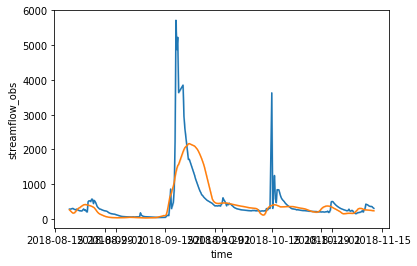

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x='time',y='streamflow_mod',data=df_lt120,ax=ax)
sns.lineplot(x='time',y='streamflow_obs',data=df_lt120,ax=ax)

In [11]:
path, score = dtw_path(s1=df_lt120['streamflow_mod'],
                       s2=df_lt120['streamflow_obs'],
                       global_constraint='sakoe_chiba',
                       sakoe_chiba_radius=3)

In [12]:
path_df = pd.DataFrame(path)
(path_df[0]-path_df[1]).mean()

0.947582993593477

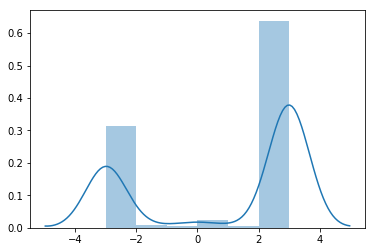

In [13]:
sns.distplot(path_df[0]-path_df[1])

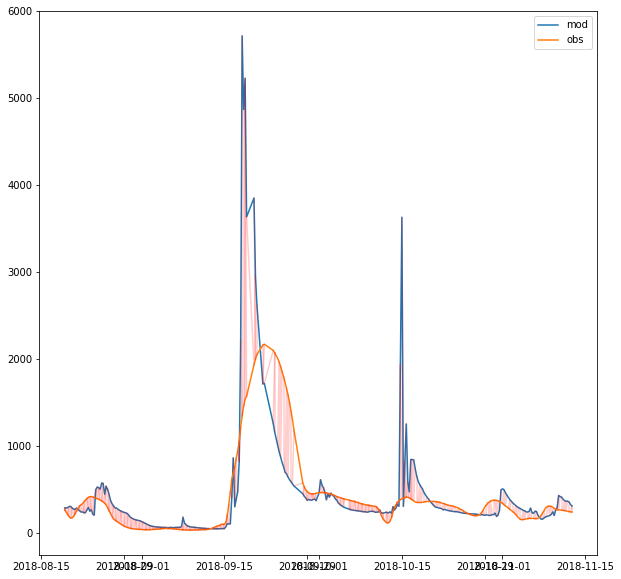

In [14]:
plt.figure(figsize=(10,10))
plt.plot(df_lt120['time'], df_lt120['streamflow_mod'] ,label='mod')
plt.plot(df_lt120['time'], df_lt120['streamflow_obs'] ,label='obs')
plt.legend();
for [map_x, map_y] in path[::5]:
#    #print map_x, x[map_x], ":", map_y, y[map_y]
    
    plt.plot([df_lt120['time'].iloc[map_x], df_lt120['time'].iloc[map_y]], 
              [df_lt120['streamflow_mod'].iloc[map_x], df_lt120['streamflow_obs'].iloc[map_y]], 'r', alpha=0.2)